# Filtering EEG Data

As described in the previous section on [Time and Frequency Domains](./time_freq), a complex time-varying signal like EEG can be represented as a combination of sine waves of many different frequencies. Human EEG largely comprises signal power in a range of frequencies from 1–30 Hz; there is some evidence that higher frequencies may also carry important neurophysiological information, however in most EEG studies — and certainly in ERP studies — the vast majority of research questions concerns EEG signals in the 1–30 Hz frequency range. 

Sources of noise also manifest as oscillating frequencies that are picked up by EEG. In particular, *low frequency noise* comes from sources such as movement of the head and electrode wires, and perspiration on the scalp. Low frequency noise appears as slow drifts in the EEG signal over many seconds. In contrast, *high frequency noise* comes from sources including electromagnetic interference, and muscle contractions (especially facial and neck muscles). High frequency noise looks like rapid up-down changes (like the teeth of a saw) in the EEG. 

The frequency of high and low frequency sources of noise may overlap with the 1-30 Hz EEG band of interest, but in general they tend to be lower and higher, respectively, than human EEG. This means that by reducing the power of the signal at the frequencies above and below the range of experimental interest, we can reduce noise with minimal impact on the signals of interest. This process is called **filtering**.

Filtering typically occurs at two points in the EEG pipeline: first at the time the data are recorded, and secondly during preprocessing. When EEG data are collected, the EEG amplifier will at the very least have a filter that cuts off frequencies that are higher than a certain threshold. This is called the **low pass filter cutoff**, because the filter "passes" lower frequencies through, but attenuates (reduces) higher frequencies. A low pass filter is absolutely *necessary* during digital recording of EEG (or any signal), because of a phenomenon known as **aliasing**. This occurs when a high-frequency signal is sampled at a rate lower than the frequency of the signal, and the result is an artifact (an artificial signal that distorts our true signal) at a much lower frequency than the actual high-frequency source. 

### Aliasing

Simply knowing that aliasing causes high-frequency noise to be represented in the data as low-frequency artifacts — and that for this reason it's necessary to use a low-pass filter — is the most critical thing for someone doing EEG research. However, it's good to understand this phenomenon a little deeper. 

For example, in the current data set the EEG was recorded with a sampling rate of 500 Hz, meaning we obtained a measurement from each electrode every 2 ms. This is a sufficient sampling rate to detect an EEG signal at 30 Hz, because over the course of each cycle of the 30 Hz oscillation (e.g., from one peak to the next), which would last 1/30th of a second, we would have 500/30  $\approx$ 17 measurements of the waveform — so we should have enough samples to accurately reflect the shape of the oscillating sine wave. 

In contrast, imagine that during the recording, there was an electromagnetic (noise) signal present in the environment that oscillated at 1700 Hz. Thus in 1 second, the noise signal would have 1700 oscillations, but our EEG amplifier could not detect this, since it is only sampling 500 times per second. In fact, 3.4 oscillations of the noise waveform would occur between every sample acquired by the EEG amplifier. Since 1700 is not an even multiple of 500, each sample acquired by our EEG amplifier would also capture a different *phase* of the 1700 Hz oscillation — that is, sometimes its peak, sometimes its trough, and sometimes somewhere in between. When we "connect the dots" between these samples to draw our measured EEG signal, these measurements at different points in the oscillation will end up looking like a much lower-frequency oscillation. The figure below shows examples of aliasing. In each subplot, the true signal is the black dotted line - a sine wave. The red dots represent samples taken at different sampling rates that are significantly below the frequency of the signal. When we connect the dots between the red lines, we can see that the high-frequency signal is aliased as a low frequency waveform.

![aliasing figure](images/aliasing.png)

Because of aliasing, the highest frequency that one can accurately record at a given sampling rate is called the **Nyquist frequency**. This can be defined as either 1/2 or 1/3 of the sampling rate. In general, you should use 1/3 because it is safest. Using 1/2 is acceptable only if you can guarantee that your noise sources and your signal are *phase locked*, meaning (in a simplified way) that their peaks and troughs are synchronized with each other. Since we can't guarantee this in real-world situations where noise is unpredictable, the 1/3 rule should be used.

As noted above, most EEG hardware automatically low-pass filters data at the time it is recorded (called **online filtering**), using a threshold determined by the hardware engineers to prevent aliasing. As we can see below, MNE reports that our data was low-pass-filtered at 80 Hz during recording, which is very comfortably below the Nyquist frequency. A highpass filter of 0.01 Hz was also applied, which would have the effect of removing very slow drift in the recording (note that 0.01 Hz is equivalent to one cycle of a sine wave every 100 s).

### Import MNE and import raw data

~~~python
import mne
mne.set_log_level('error')  # reduce extraneous MNE output

# Participant ID code
p_id = 'N400_dataset_14'
data_dir = 'data'
raw_file = data_dir + '/' + p_id + '.vhdr'
raw = mne.io.read_raw_brainvision(raw_file, preload=True)

# Set electrode locations
montage = 'standard_1005' # Electrode position file
raw.set_montage(montage)
~~~

In [3]:
import mne
mne.set_log_level('error') 

p_id = 'sub-001'
data_dir = 'data/' + p_id + '/'

raw_file = data_dir + p_id + '.vhdr'

raw = mne.io.read_raw_brainvision(raw_file, preload=True)

montage = 'easycap-M1' 
raw.set_montage(montage)

Measurement date,"January 20, 2015 13:15:58 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.01 Hz
Lowpass,80.00 Hz


### Offline filtering

**Offline** is a term that is generally used in EEG to refer to processing steps that are applied after the data are collected, in contrast to the online processing that is applied when data are collected. So, the low-pass filter used during recording to prevent aliasing is an example of an online filter, while filtering that we apply in a script like this is offline filtering. 

Offline filtering serves to remove more noise from the data than online filtering. In general, EEG researchers prefer to record with a wider range of filter settings, in part because filters can cause distortions to the data, particularly if the cutoffs are too close to the range of frequencies of interest. Any online filter that is applied to the data is permanent, since the data are originally recorded that way — there is no "undo" option. In contrast, with offline filtering one can apply different filters and observe the results on the data, and re-load the original data and use different filter settings if necessary. 

### Offline filter settings

We defined our filter cutoffs in the parameters section above, and the settings used are pretty standard in the world of ERP analysis: a high-pass (low frequency) cutoff of 0.1 Hz, and a low-pass (high frequency) cutoff of 30 Hz (some researchers use 40 Hz instead). Together, this is called a **band pass filter**, because we preseve a "band" of frequencies between the high-pass and low-pass cutoffs. 

These settings strike an optimal balance between attenuating artifacts outside the range of human EEG signals of interest, without inducing artifacts of their own. These artifacts typically occur if the filter cutoffs are too close to the range of frequencies of scientific interest. It turns out that the high-pass cutoff needs to be much lower (by a factor of about 10) than the lowest frequency of interest (hence 0.1 when our lowest frequency of interest is 1 Hz), while the low-pass cutoff can be much closer to the highest frequency of interest (in most ERP research, components of interest are rarely higher than about 10 Hz).

### Always filter first

Filtering should always be one of the first preprocessing steps you apply to your data. Most importantly, filtering should be applied to the continuous, raw EEG data before it is chopped into short segments time-locked to the event codes of interest. This is because we need long segments of data in order to accurately estimate and remove low frequencies. For example, our low frequency cutoff of 0.1 Hz corresponds to one sine wave oscillation every 10 sec, and we would need 20-30 s of data to estimate this accurately. A typical segment of data for ERP analysis is only about 1-2 s long at most, and so once your data are segmented, you can't remove low frequencies. Even for high frequencies, filtering results in removing the first and last few data points from the data (for technical reasons we won't cover here), and so again it's better to filter at the start and not worry about it later.

MNE provides a `.filter()` method for `Raw` data that is simple to apply, but is actually very powerful because of the many options provided. If you're interested in more detailed discussion of how filtering works, both in general and in MNE, their website has a very detailed [discussion of filtering](https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html).

### Plot the frequency spectrum of the raw data

MNE's `.plot_psd()` method plots the **power spectral density** (PSD) of a data set. *Power* refers to the amplitude of sine waves when we are working in the frequency domain, *spectrum* means a range of frequencies, and *density* basically means we're quantifying the power over a range of frequencies. In a sense, you can think of a PSD as a histogram of frequency information — frequency is a continuous variable that is divided into bins (bin size is determined automatically), and the amount of power is plotted for each frequency bin. We set the `fmax` kwarg to 100 because we aren't interested in frequencies above this.

MNE automatically colour-codes electrodes based on their position on the scalp, as shown in the inset to the figure, and the lines in the PSD represent the data from each corresponding electrode. 

~~~python
raw.plot_psd(fmax=100);
~~~

/opt/anaconda3/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


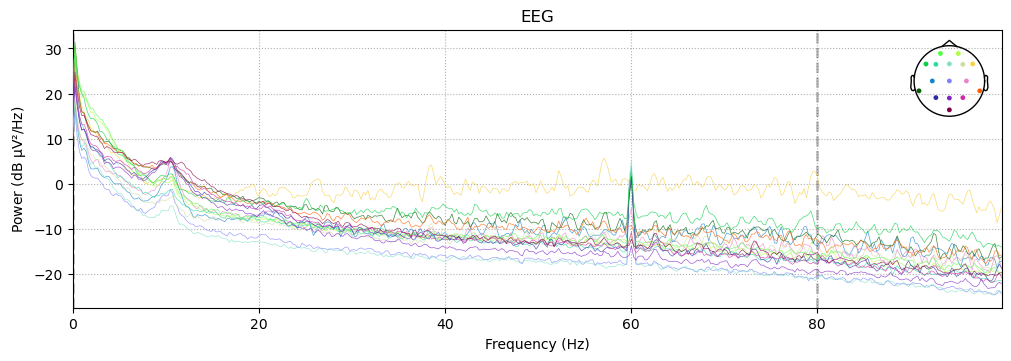

In [9]:
raw.plot_psd(fmax=100)

The PSD shows a clear spike at 60 Hz, which is the frequency of AC electrical service in Canada, where the data was recorded. This is the electromagnetic interference mentioned above.

The PSD also shows a typical property of human EEG (and many other frequency spectra), known as the **1 / *f*** property. That is, power is highest at the lowest frequencies, and drops off with increasing frequency. The dropoff is not linear (a diagonal line), but rather decreases at approximately 1 divided by the frequency. 

The vertical dashed line shows the low-pass cutoff that was used during data acquisition. This information was stored in the EEG header file, and read by MNE when the data was imported.

### Filter the raw data

We define a set of parameters for the filter command first, then run it. The important (required) parameters are `hi_cut` and `low_cut`, and here we are specifying a bandpass filter with a low frequency (highpass) cutoff of 0.1 Hz, and a high frequency (lowpass) cutoff of 30 Hz. There are many other parameters that can be set, as MNE's filtering function is quite robust. However, the defaults for these parameters have been set to already be optimized for most EEG and MEG data. 

We need to chain the `.copy()` and `.filter()` methods because by default, the `.filter()` method modifies the raw data in-place, rather than creating a new, filtered copy of the data. This is sensible for managing the memory used, but can create problems if we want to change the filter settings and redo the filtering step. 

~~~python
# Filter settings
low_cut = 0.1
hi_cut  = 30

raw_filt = raw.copy().filter(low_cut, hi_cut)
~~~

In [10]:
low_cut = 0.1
hi_cut = 30

raw_filt = raw.copy().filter(low_cut, hi_cut)

### Plot the frequency spectrum of the filtered data


~~~python
raw_filt.plot_psd(fmax=100);
~~~

/opt/anaconda3/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


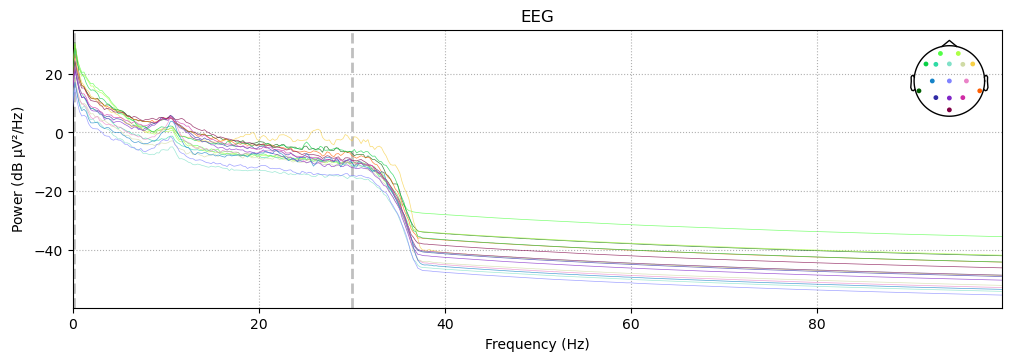

In [12]:
raw_filt.plot_psd(fmax=100)

The effects of our low-pass filter are quite evident — in comparison to the pre-filtering PSD, there is a dramatic drop in power above our 30 Hz cutoff (note that the dashed line has moved to reflect our new low-pass cutoff). The spike at 60 Hz is gone (actually it's still there, but very small), because the filtering virtually eliminated this noise from the data. 

The effects of the high-pass filtering are much harder to see, since the scale is linear from 0–100 Hz, but our cutoff of 0.1 Hz was very close to zero. If we set `fmax` to 10 we can see the effects of the high-pass cutoff more clearly:

~~~python
raw_filt.plot_psd(fmax=10);
~~~

/opt/anaconda3/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


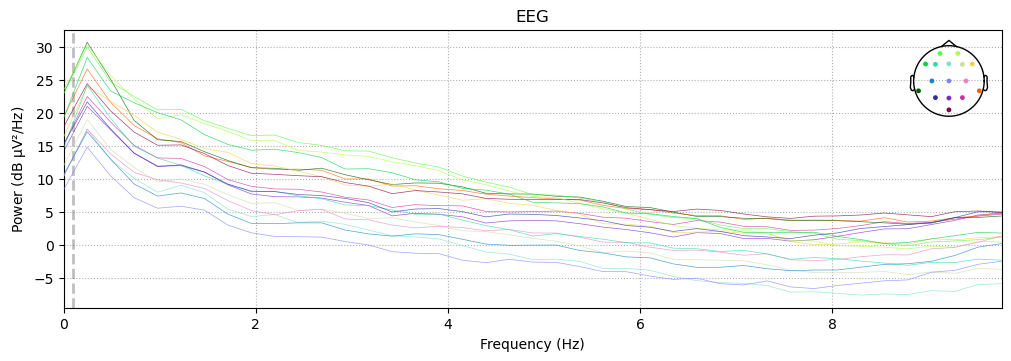

In [13]:
raw_filt.plot_psd(fmax=10)

Note that for both the high- and low-pass filters, the power does not drop of sharply right at the cutoff frequency we specified. Rather, there is a **roll-off** — a range of frequencies over which the power gradually decreases. The shape of the roll-off is a property of the filter that is determined by its parameters, and some roll-off is a necessary feature of any filter if aftifacts are to be avoided. Again, this is a deep topic that we won't delve into here, but in general it is useful to remember the adage that *precision in the frequency domain is inversely related to precision in the time domain*. In other words, if we use a sharper frequency cutoff, we are likely to induce larger artifacts in the data, when we view the filtered data in the time domain. 

### Visualizing the effects of filtering in the time domain

Below we plot 5 s of data, comparing the raw and filtered versions.

#### Unfiltered

Note the high frequency noise in virtually all channels — the oscillations that occur very rapidly. This is particularly large in channel F8. This is primarily 60 Hz line noise. 

Channels F8 and Fp2 show low frequency noise as well — these are the slow drifts up and down seen in these channels. It can help to imagine a horizontal line to compare an EEG tracing to, to identify slow drift over the entire time period shown.

~~~python
raw.plot(start=15, duration=5);  # times are in seconds
~~~

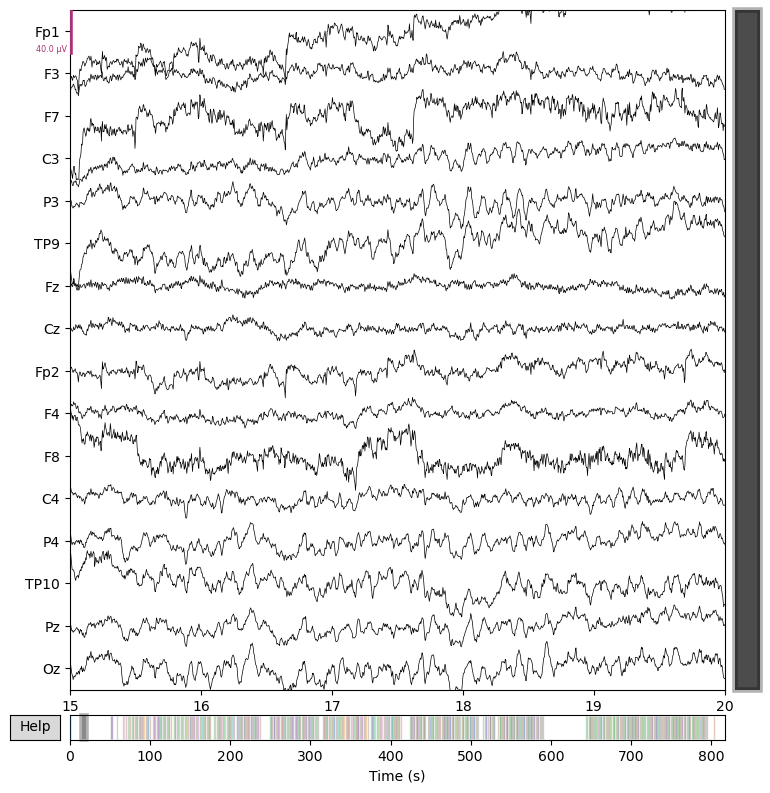

In [16]:
raw.plot(start=15, duration=5);

#### Filtered

The plot below shows the same sample of data after filtering. The high frequency noise is gone. The low-frequency noise is perhaps a bit reduced, but not eliminated. This is because our high-pass filter setting was 0.1 Hz, which means that only frequencies below 1 cycle per 10 sec would be reduced. These are so slow that we would not even see much evidence of them in 5 sec of data. Although we could filter the data with a higher high-pass cutoff (e.g., 1 Hz instead of 0.1 Hz), this risks inducing artifacts into the data ([Tanner, Morgan-Short, & Luck, 2015](https://doi.org/10.1111/psyp.12437)), so we don't. 

~~~python
raw_filt.plot(start=15, duration=5);
~~~

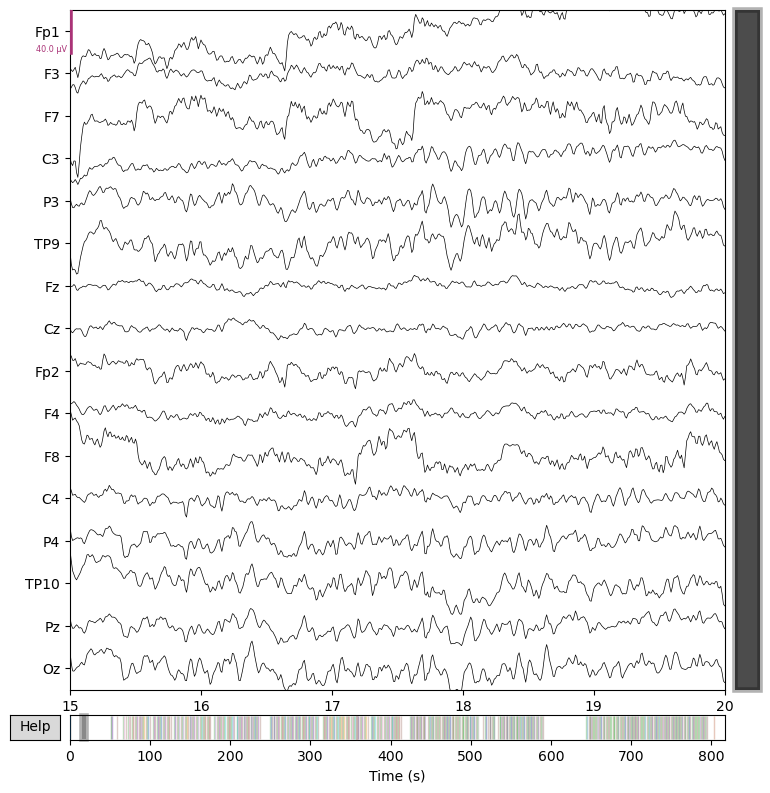

In [17]:
raw_filt.plot(start=15, duration=5);

## Save filtered data

Since each step of preprocessing is a separate Jupyter notebook, we will save our data after applying each step so we can load it in the next notebook, rather than re-running preceding steps each time.

MNE data types all have a `.save()` method that allows you to save them to files. MNE uses a file format called `.fif`. This format was originally developed by a company that makes MEG scanners, called Elekta Neuromag. MNE was originally developed for working with data from these scanners, which is why this format was adopted. It is a well-documented and accessible format that many other software packages can read, so it is a good choice. 

~~~python
raw_filt.save(data_dir + '/' + p_id + '-filt-raw.fif', 
              overwrite=True)
~~~

In [18]:
raw_filt.save(data_dir + p_id + "-filt-raw.fif",
              overwrite=True)

In the next lesson we will also need the unfiltered raw data, so we will also save it here as a .fif file:

~~~python
raw.save(data_dir + '/' + p_id + '-raw.fif', 
         overwrite=True)
~~~

In [19]:
raw.save(data_dir + p_id + "raw.fif",
         overwrite=True)